In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from matplotlib import pyplot as plt
import tensorflow as tf
from keras import layers
import os

ModuleNotFoundError: No module named 'tensorflow'

# Project Topic


Explanation: Sentiment analysis is one of the crowning achievements of recent advances in machine learning. In its most naive form, sentiment analysis is a simple binary classification with two possible label outputs, calculated as a function of an input string. In the case that we will explore, the input string is a single movie review, and the corpus of documents is all of the full text movie reviews in the dataset. The basic strategy for sentiment analysis includes drawing inferences and making predictions based on the relative importance and prominence of a word within a sequence or given document against the corpus of all documents. In this report, we will be utilizing unsupervised, supervised, and deep learning methods to estimate sentiment analysis on a corpus of documents.

Our strategy in this report will be to use the tfidf vectorizer from sklearn to create a vocabulary and sparse matrix for each document. Then we will build a supervised model with the Random Forest Classifier, using Randomized Search CV to tune the hyperparameters for both the vectorizer and the Random Forest Classifier as a benchmark. Finally, we will build a multilayer neural network with Keras, that uses our sparse matrix and vocabulary as input, and determines the appropriate label as an output.
Motivation: My motivation is to wield the full spectrum of techniques across unsupervised, supervised, and deep learning that we have learned this semester in a cohesive end-to-end model, and to compare the results between these approaches.

# Data
Source: Kaggle.com "Bag of Words Meets Bags of Popcorn" https://www.kaggle.com/competitions/word2vec-nlp-tutorial/data
Description: The Bag of Words Meets Bags of Popcorn Dataset is the dataset used in an NLP tutorial on Kaggle.com. I have not previously viewed or completed this tutorial and do not intend to use the techniques and methods described in the tutorial in the completion of my project.

The dataset includes three features "id" (categorical), "sentiment" (numerical), and "review" (categorical). There are 75,000 total observations (25,000 train observations, and 50,000 test observations) in the dataset. The train observations are labeled with sentiment 1.0 or 0.0, where a review was scored either >= 7 or < 7 respectively. There are no null values, in the train dataset.

Given we do not have the labels for the test dataset, we will have to use a portion of the train data set for validation purposes, and we will not be able to fully evaluate the efficacy of our model.

In [2]:
class RecommenderSystem:
    def __init__(self, train, test):
        self.ntrain = len(train)
        self.ntest = len(test)
        self.X = pd.concat([trainLabeled, test]).dropna(how='all')
        self.test = np.asarray(self.X[self.ntrain:])

    def vectorize(self, max_features):
        vectorizer = TfidfVectorizer(max_features=max_features)
        Xtfidf = vectorizer.fit_transform(self.X['review'])
        self.vocab = np.asarray(vectorizer.get_feature_names_out())
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(Xtfidf[:self.ntrain], np.asarray(self.X[:self.ntrain]['sentiment']))
        return self
    def fit(self, model):
        self.model = model
        model.fit(self.X_train, self.y_train)
        return self

    def predict(self):
        self.yp = self.model.predict(self.X_test)
        return self

    def score(self):
        return accuracy_score(self.y_test, self.yp)

trainLabeled = pd.read_csv('./data/labeledTrainData.tsv', sep='\t', header=0, quoting=3).set_index('id')
test = pd.read_csv('./data/unlabeledTrainData.tsv', sep='\t', header=0, quoting=3).set_index('id').drop('Unnamed: 2',axis=1)

rm = RecommenderSystem(trainLabeled, test)

# Data Cleaning and EDA
Explanation of how and why cleaning is performed:

The cleaning that we need to do on this dataset is limited to the cleaning and parsing of strings, and resulting transformation into a sparse matrix for input into subsequent models. Looking at the reviews, we can see that the text is ascii, however, we will need to make sure that all of the words are lowercase, that all punctuation and special characters are removed, that all stop words are eliminated.

The sklearn vectorizers will perform these transformations for us automatically when we pass our full dataset to the fit_transform function. TFIDF does not remove stop words, however, by setting max_features at any reasonable threshold, we will eliminate those tokens which are most common to all documents in the corpus and thus, least meaningful, implicitly eliminating the stop words for us.

To transform the data into a sparse matrix, we are going to use a textvectorizer that calculates the term frequency, inverse document frequency (TFIDF) of each word in each document. This will produce a vocabulary for us that consists of a vector of length (max_features) where each element of the vector corresponds with a word in our vocabulary. Our vocabulary will be derived from the full set of all reviews (training and test). As we learned in previous assignments, we can derive our vocabulary from the entire corpus of documents, without biasing our model. This is because our TFIDF vectorizer is not aware of the labels associated with each observation, and is merely deriving the relationship between words and documents in the corpus.

We will chose TFIDF over a basic CountVectorizer, given the basic objective of sentiment analysis is identifying the magnitude and direction of each word as it relates to the cumulative sentiment of the document. A simple word count would be too likely to include words that are frequently used but have low meaning.

Visualizations: Due to the high dimensionality of the dataset, I will not be able to create meaningful visual graphs of the data, and will instead rely on data tables.


In [3]:
#We can call vectorize with parameter None, this will set max_features = None, and produce a sparse matrix with all words in the corpus included in the vocabulary
rm.vectorize(None)
print(f"there are {len(rm.vocab)} words in the corpus")

there are 124273 words in the corpus


In [25]:
#Demonstration that we can recover the original text from each review by finding the inner product of the tfidf transformed X_train set and the vocabulary
nzi = np.nonzero(rm.X_train[0].reshape((rm.X_train.shape[1],1)))
unique_words_in_first_doc = rm.vocab[nzi[0]]
unique_words_in_first_doc

array(['afterwords', 'gadgets', 'gadget', 'murky', 'faults',
       'lighthearted', 'fascination', 'wished', 'miscast', 'broderick',
       'interested', 'admittedly', 'college', 'considered', 'became',
       'missing', 'exists', 'besides', 'reasonable', 'crazy', 'smart',
       'legacy', 'went', 'cartoon', 'charming', 'might', 'treatment',
       'charm', 'deserve', 'enjoyable', 'live', 'wacky', 'attitude',
       'thing', 'before', 'seeing', 'seriously', 'interesting', 'back',
       'enough', 'grade', 'saw', 'role', 'were', 'naturally', 'used',
       'while', 'far', 'perhaps', 'rather', 'funny', 'around', 'been',
       'liked', 'action', 'itself', 'original', 'fun', 'plot', 'took',
       'doesn', 'even', 'close', 'didn', 'earth', 'too', 'picture',
       'motion', 'much', 'seem', 'story', 'effects', 'though', 'its',
       'what', 'never', 'being', 'version', 'great', 'very', 'be', 'had',
       'have', 'as', 'on', 'only', 'if', 'made', 'that', 'movie', 'like',
       'br', 'abo

# Model building/ Model Choice

Our model building will consist of 2 independent models. The first will be a supervised learning model with a Random Forest Classifier. The second will be a deep learning model with a Multilayer Neural Network. We choose these two models as a demonstration that unsupervised learning on a dataset to reduce the number of dimensions that each model is fit on, is effective for both a supervised and deep learning approach. In fact a combination of all of these approaches is best for truly understanding and evaluating such a large dataset, with as many features as ours has. The choice of RandomForestClassifier is obvious for data classification given it is robust to high dimensionality data sets, the interpretability of the model, and the nonlinearity that aligns well with our nonlinear corpus.

In the first phase, we will want to tune the hyperparameters for both our TfidfVectorizer and our RandomForestClassifier. The relevant parameters to tune for the Tfidf are the max_features, which indicates the total numbers of words included in our vocabulary ordered by their rank, and for the RandomForestClassifier, we will choose number of estimators (i.e., the number of decision trees in the forest) and the max depth which is the longest path from root to leaf within the tree.

We will use RandomizedSearchCV to select 1/5 folds of data for validation and the other 4/5 for training. Then it will randomly select combinations of the hyperparameters as specified in our hyper parameter grid. We choose RandomSearchCV because an exhaustive GridSearchCV would be too computationally intensive given the size of the dataset and the time taken to fit a randomforestclassifier with >100 estimators. Thus, we can specify the max number of iterations before halting.

In [26]:
pipeline = Pipeline(
    [
        ("vectorizer", TfidfVectorizer()),
        ("est", RandomForestClassifier()),
    ]
)
pipeline

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('est', RandomForestClassifier())])

In [27]:
parameter_grid = {
    "vectorizer__max_features": (5000, 10000,15000,20000),
    "est__n_estimators": ( 100, 200, 300),
    "est__max_depth": (5, 15, 30),
}
rscv = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=parameter_grid,
    n_iter=25,
    n_jobs=-1,
    verbose=1
)
rscv.fit(trainLabeled.review, trainLabeled.sentiment)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


RandomizedSearchCV(estimator=Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                                             ('est',
                                              RandomForestClassifier())]),
                   n_iter=25, n_jobs=-1,
                   param_distributions={'est__max_depth': (5, 15, 30),
                                        'est__n_estimators': (100, 200, 300),
                                        'vectorizer__max_features': (5000,
                                                                     10000,
                                                                     15000,
                                                                     20000)},
                   verbose=1)

In [32]:
df = pd.DataFrame(rscv.cv_results_)

Now that we've completed our RandomizedSearchCV, we can evaluate the dataframe and look at the mean fit time and mean fit score for each set of hyperparameters tested on our 5-fold cross validation.

In [33]:
df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_vectorizer__max_features,param_est__n_estimators,param_est__max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,77.726650,0.694767,4.772267,0.121720,15000,200,30,"{'vectorizer__max_features': 15000, 'est__n_es...",0.8374,0.8426,0.8420,0.8514,0.8458,0.84384,0.004634,1
1,22.653149,1.005098,3.995637,0.987942,15000,300,5,"{'vectorizer__max_features': 15000, 'est__n_es...",0.8152,0.8210,0.8146,0.8200,0.8178,0.81772,0.002532,23
2,25.474395,1.263212,3.148176,0.643088,5000,100,15,"{'vectorizer__max_features': 5000, 'est__n_est...",0.8196,0.8266,0.8300,0.8324,0.8292,0.82756,0.004390,18
3,18.812101,0.286187,2.982726,0.119216,20000,300,5,"{'vectorizer__max_features': 20000, 'est__n_es...",0.8198,0.8208,0.8190,0.8304,0.8266,0.82332,0.004434,19
4,19.829720,1.744731,4.132402,0.853231,5000,200,5,"{'vectorizer__max_features': 5000, 'est__n_est...",0.8058,0.8192,0.8098,0.8188,0.8202,0.81476,0.005840,25
5,76.539661,1.091985,2.816238,0.083034,20000,200,30,"{'vectorizer__max_features': 20000, 'est__n_es...",0.8356,0.8424,0.8380,0.8470,0.8416,0.84092,0.003910,5
6,57.310531,4.774374,2.995095,0.410694,5000,300,15,"{'vectorizer__max_features': 5000, 'est__n_est...",0.8284,0.8336,0.8258,0.8388,0.8342,0.83216,0.004581,14
7,108.084574,0.442638,2.714026,0.085175,5000,300,30,"{'vectorizer__max_features': 5000, 'est__n_est...",0.8304,0.8412,0.8390,0.8476,0.8400,0.83964,0.005508,8
8,74.050636,1.998914,2.662436,0.317836,5000,200,30,"{'vectorizer__max_features': 5000, 'est__n_est...",0.8328,0.8424,0.8352,0.8464,0.8426,0.83988,0.005065,7
9,32.544724,0.656039,2.408186,0.249703,20000,100,30,"{'vectorizer__max_features': 20000, 'est__n_es...",0.8270,0.8332,0.8330,0.8448,0.8396,0.83552,0.006117,11


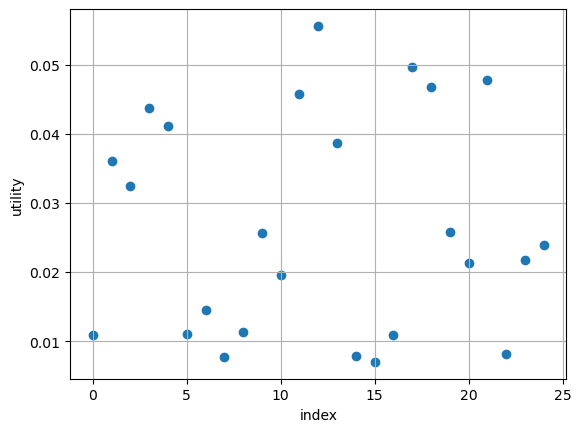

In [38]:
#We will plot the score over the time taken to fit the matrix to visually represent the trade off in accuracy vs resources consumed for each set of hyperparameters
X = df.mean_fit_time
y = df.mean_test_score
plt.scatter(X.index, y/X)
plt.xlabel('index')
plt.ylabel('utility')
plt.grid()

In [35]:
df.loc[np.argmax(y/X)].params

{'vectorizer__max_features': 15000,
 'est__n_estimators': 200,
 'est__max_depth': 5}

In [36]:
for param in sorted(parameter_grid.keys()):
    print(f"{param} : {rscv.best_estimator_.get_params()[param]}")

est__max_depth : 30
est__n_estimators : 200
vectorizer__max_features : 15000


Above we display both the parameter set with the highest Utility, and the parameter set that produces the highest mean accuracy score. We measure utility as Score/Time, such that we pick not only the set that produces the best of hyperparameters that produces the best model, but also the one that takes the least time. We can compare that to the best over all hyper parameters and see that the the only difference between the two sets is that the max_depth is 5 when we maximize utility vs 30 when we are maxiziming accuracy without regard to the time take for the model to fit.

In [37]:
rm = RecommenderSystem(trainLabeled, test)
best_max_depth = rscv.best_estimator_.get_params()['est__max_depth']
best_n_estimators = rscv.best_estimator_.get_params()['est__n_estimators']
best_max_features = rscv.best_estimator_.get_params()['vectorizer__max_features']
rm.vectorize(best_max_features)
forest = RandomForestClassifier(max_depth=best_max_depth,n_estimators=best_n_estimators)
rm.fit(forest).predict().score()

0.84112

When we choose the best hyperparameter set we found and then predict based on the validation dataset, we determine that the baseline score for our tuned RandomForestClassifier is 84% accurate at binary classification for sentiment analysis.

Next we will use the Keras library to build a rudimentary feed-forward neural network with just two regular Dense neural layers. We will use the sigmoid function for the output layer activation function, because this is a binary classification problem, and each answer should either be 0 or 1. The benefit of performing unsupervised learning, as we did early when we factored the original corpus of documents into two matrices (a vocabulary, and a tfidf sparse matrix), is that we can feed the same sparse matrix directly into our neural network without needing to use an embedding layer or an external embedding library.

We will also be able to evaluate the effectiveness of even a very basic neural network compared to our RandomForestClassifier which required extensive hyperparameter tuning and preprocessing, at a significant cost of time, to implement.

We will use the Adam optimization function, which is similar to Stochastic Gradient Descent, while being more computationally efficient and less memory intensive. We will use binary cross entropy loss, which is common for classification problems as a way of measuring error rate of predicted versus actual. We will additionally print out the accuracy of each epoch. We will use 3 epochs for our training, which means that each layer of the neural network will be trained on the entire corpus 3 times.

In [204]:
inputs = keras.Input(shape=(rm.X_train.shape[1],))

dense = layers.Dense(64, activation="relu")
x = dense(inputs)
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1,activation="sigmoid",name="predictions")(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="movie_reviews")
model.compile(
    optimizer = "adam",
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

model.fit(rm.X_train.todense(), rm.y_train, batch_size=64, epochs=3, validation_data=(rm.X_test.todense(),rm.y_test))

Epoch 1/3
293/293 [==============================] - 1s 4ms/step - loss: 0.3633 - accuracy: 0.8534 - val_loss: 0.2453 - val_accuracy: 0.8982
Epoch 2/3
293/293 [==============================] - 1s 3ms/step - loss: 0.1262 - accuracy: 0.9590 - val_loss: 0.2825 - val_accuracy: 0.8918
Epoch 3/3
293/293 [==============================] - 1s 3ms/step - loss: 0.0515 - accuracy: 0.9864 - val_loss: 0.3791 - val_accuracy: 0.8832


In [205]:
model.predict(rm.X_test[:3])

1/1 [==============================] - 0s 27ms/step


array([[9.9977934e-01],
       [1.5073504e-04],
       [2.5365336e-04]], dtype=float32)

In [206]:
model.summary()

Model: "movie_reviews"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 20000)]           0         
                                                                 
 dense_37 (Dense)            (None, 64)                1280064   
                                                                 
 dense_38 (Dense)            (None, 64)                4160      
                                                                 
 predictions (Dense)         (None, 1)                 65        
                                                                 
Total params: 1284289 (4.90 MB)
Trainable params: 1284289 (4.90 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Results and Analysis

We can see that even an extremely naive implementation of the neural network achieves astounding results. With only 2 hidden layers of 64 neurons, we were still able to achieve over 89% prediction accuracy on the validation test set! That's a 5% improvement raw on our RandomForestClassifier at 84% accuracy on the validation set. The Netflix prize only required a 10% improvement! Additionally, our neural can be readily expanded to include additional layers of different types of neurons, including combinations of convolutional neurons, additional embeddings, different activations, and even recurrent neural network  frameworks.

This illustrates the power and flexibility of preprocessing data and extracting features with unsupervised learning methods, as we can use both supervised and  deep learning methods on top of reduced dimension dataset with surprisingly effective results. An end-to-end model will likely use a combination of supervised, unsupervised, and deep learning, as well as preprocessing, cross validation, feature extraction, and other methods to empirically produce the most accurate and flexible model in a production enviornment
